## Kompozyt (ang. Composite)

**Typ**: strukturalny \
**Zakres**: obiektowy

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>kompozyt</b> komponuje obiekty w struktury drzewiaste w celu reprezentowania hierarchii typu część-całość. Kompozyt pozwala klientom traktować jednakowo obiekty pojedyncze oraz złożone.
</div>

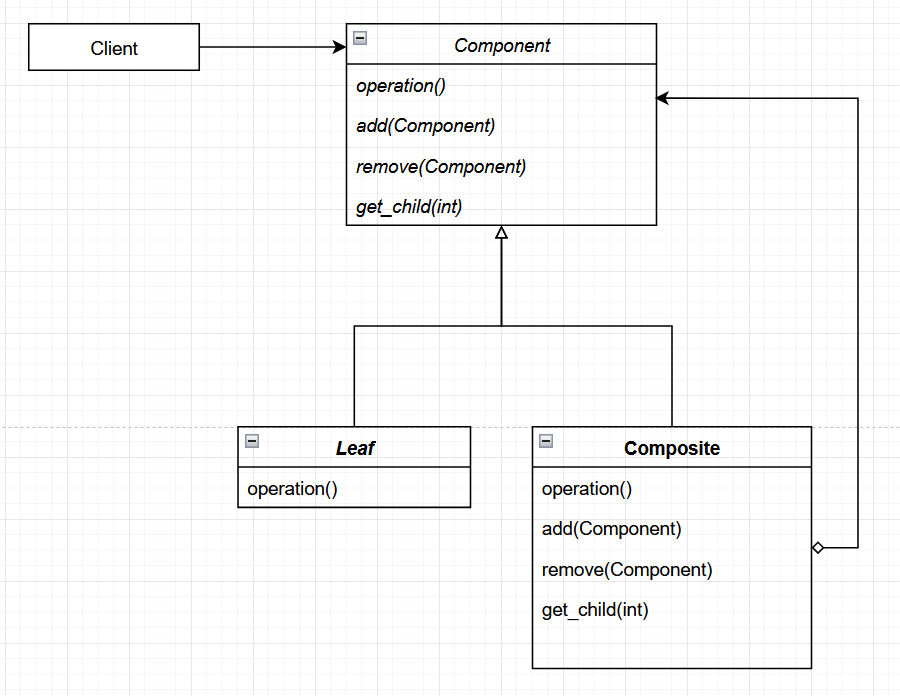

### Problem - jak traktować jednakowo pojedynczy element i grupę?

Masz system plików. Chcesz obliczyć rozmiar:
- **Plik** - zwróć jego rozmiar
- **Folder** - zsumuj rozmiary wszystkich plików i podfolderów

Jak to zrobić bez `if isinstance()`?

### Naiwne podejście - różne klasy, różne API

In [ ]:
class File:
    def __init__(self, name, size):
        self.name = name
        self.size = size
    
    def get_size(self):
        return self.size


class Folder:
    def __init__(self, name):
        self.name = name
        self.children = []  # Lista plików i folderów
    
    def add(self, item):
        self.children.append(item)
    
    def get_size(self):
        total = 0
        for child in self.children:
            # ❌ Musimy sprawdzać typ!
            if isinstance(child, File):
                total += child.get_size()
            elif isinstance(child, Folder):
                total += child.get_size()  # Rekurencja
        return total

In [ ]:
# Struktura:
# root/
#   file1.txt (100 KB)
#   file2.txt (200 KB)
#   subfolder/
#     file3.txt (50 KB)

file1 = File("file1.txt", 100)
file2 = File("file2.txt", 200)
file3 = File("file3.txt", 50)

subfolder = Folder("subfolder")
subfolder.add(file3)

root = Folder("root")
root.add(file1)
root.add(file2)
root.add(subfolder)

print(f"Rozmiar root: {root.get_size()} KB")

**Problemy:**
- ❌ `Folder.get_size()` musi sprawdzać `isinstance()` dla każdego dziecka
- ❌ Co jeśli dodamy nowy typ (np. `Symlink`)? **Trzeba zmienić** `Folder.get_size()`!
- ❌ Klient musi znać różnicę między `File` a `Folder`
- ❌ **Nie możesz traktować ich jednakowo**

### Rozwiązanie - wzorzec Kompozyt

**Idea:** Plik i Folder mają **ten sam interfejs**. Klient traktuje je **identycznie**.

### Krok 1: Wspólny interfejs Component

In [ ]:
from abc import ABC, abstractmethod

class FileSystemComponent(ABC):
    """Wspólny interfejs dla plików i folderów"""
    
    @abstractmethod
    def get_size(self):
        """Zwraca rozmiar - dla pliku i folderu!"""
        pass
    
    @abstractmethod
    def display(self, indent=0):
        """Wyświetla strukturę"""
        pass

### Krok 2: Leaf (liść) - pojedynczy element

In [ ]:
class File(FileSystemComponent):
    """Liść - pojedynczy plik (nie ma dzieci)"""
    
    def __init__(self, name, size):
        self.name = name
        self.size = size
    
    def get_size(self):
        return self.size  # Zwraca swój rozmiar
    
    def display(self, indent=0):
        print(" " * indent + f"📄 {self.name} ({self.size} KB)")

### Krok 3: Composite (kompozyt) - kontener

In [ ]:
class Folder(FileSystemComponent):
    """Kompozyt - folder (ma dzieci: pliki i inne foldery)"""
    
    def __init__(self, name):
        self.name = name
        self.children = []  # Lista FileSystemComponent
    
    def add(self, component: FileSystemComponent):
        self.children.append(component)
    
    def remove(self, component: FileSystemComponent):
        self.children.remove(component)
    
    def get_size(self):  # rekurencja
        # ✅ Bez isinstance()! Każde dziecko ma get_size()
        total = 0
        for child in self.children:
            total += child.get_size()  # Polimorfizm!
        return total
    
    def display(self, indent=0):
        print(" " * indent + f"📁 {self.name}/")
        for child in self.children:
            child.display(indent + 2)  # Rekurencja

**Kluczowa zmiana:**
- `Folder.get_size()` **NIE sprawdza typu** dziecka
- Po prostu wywołuje `child.get_size()` - **polimorfizm**!
- Każde dziecko wie jak obliczyć swój rozmiar

### Krok 4: Użycie - ten sam interfejs dla wszystkich

In [ ]:
# Budujemy strukturę:
# root/
#   file1.txt (100 KB)
#   file2.txt (200 KB)
#   subfolder/
#     file3.txt (50 KB)
#     deep/
#       file4.txt (25 KB)

file1 = File("file1.txt", 100)
file2 = File("file2.txt", 200)
file3 = File("file3.txt", 50)
file4 = File("file4.txt", 25)

deep = Folder("deep")
deep.add(file4)

subfolder = Folder("subfolder")
subfolder.add(file3)
subfolder.add(deep)  # Folder w folderze!

root = Folder("root")
root.add(file1)
root.add(file2)
root.add(subfolder)

# ✅ Traktujemy wszystko identycznie!
print("Struktura:")
root.display()

print(f"\nRozmiar całkowity: {root.get_size()} KB")
print(f"Rozmiar subfolder: {subfolder.get_size()} KB")
print(f"Rozmiar file1: {file1.get_size()} KB")

**Magia:**
- `root.get_size()` wywołuje `child.get_size()` dla każdego dziecka
- Jeśli dziecko to `File` → zwraca `self.size`
- Jeśli dziecko to `Folder` → rekurencyjnie sumuje dzieci
- **Klient nie musi wiedzieć co to jest!**

## Jak to działa? - wizualizacja wywołań

```python
root.get_size()
    ↓
    file1.get_size()     → 100
    file2.get_size()     → 200
    subfolder.get_size()
        ↓
        file3.get_size()  → 50
        deep.get_size()
            ↓
            file4.get_size() → 25
        ← 25
    ← 50 + 25 = 75
← 100 + 200 + 75 = 375
```

**Bez sprawdzania typu!** Każdy obiekt wie jak obliczyć swój rozmiar.

## Struktura wzorca

**Elementy wzorca Kompozyt:**

1. **Component** - `FileSystemComponent`
   - Wspólny interfejs dla liści i kompozytów
   - Deklaruje operacje (`get_size()`, `display()`)

2. **Leaf** - `File`
   - Pojedynczy element (nie ma dzieci)
   - Implementuje operacje bezpośrednio

3. **Composite** - `Folder`
   - Kontener (ma dzieci: Leaf lub inne Composite)
   - Implementuje operacje poprzez delegację do dzieci
   - Zarządza dziećmi (`add()`, `remove()`)

**Kluczowa właściwość:**
> Composite i Leaf implementują **ten sam interfejs** → klient traktuje je **identycznie**

## Kiedy używać wzorca Kompozyt?

Wzorzec Kompozyt stosuj gdy:

1. **Masz hierarchię typu część-całość**
   - Struktura drzewiasta
   - Obiekty zawierają inne obiekty

2. **Chcesz traktować jednakowo pojedyncze obiekty i grupy**
   - Plik = Folder (system plików)
   - Kształt = Grupa kształtów (grafika)
   - Pracownik = Menedżer z zespołem (organizacja)

3. **Chcesz uniknąć `if isinstance()`**
   - Polimorfizm zamiast sprawdzania typu

**Przykłady praktyczne:**
- System plików (plik vs folder)
- GUI (komponent vs kontener)
- Grafika (kształt vs grupa)
- Organizacja (pracownik vs menedżer)
- Menu (pozycja vs podmenu)
- Wyrażenia matematyczne (`5` vs `(2 + 3)`)

## Kluczowe zasady

**1. Wspólny interfejs**

```python
# ten sam interfejs
class Component(ABC):
    @abstractmethod
    def operation(self):
        pass

class Leaf(Component):
    def operation(self):  # Implementuje operation()
        ...

class Composite(Component):
    def operation(self):  # Też implementuje operation()
        for child in self.children:
            child.operation()
```

**2. Polimorfizm zamiast `isinstance()`**

```python
# ❌ ŹLE
for item in items:
    if isinstance(item, File):
        size += item.size
    elif isinstance(item, Folder):
        size += item.get_size()

# ✅ DOBRZE
for item in items:
    size += item.get_size()  # Polimorfizm!
```

**3. Rekurencja w Composite**

```python
class Composite(Component):
    def operation(self):
        for child in self.children:
            child.operation()  # Rekurencja - child może być Leaf lub Composite
```

## Podsumowanie

Wzorzec Kompozyt:
- ✅ **Traktuje jednakowo** pojedyncze obiekty i grupy
- ✅ **Unika `isinstance()`** - polimorfizm zamiast sprawdzania typu
- ✅ **Elastyczne budowanie** hierarchii (drzewa)
- ✅ **Łatwe dodawanie** nowych typów Leaf (bez zmiany Composite)
- ⚠️ **Może być nadmiarowy** dla prostych struktur

**Kluczowa idea:**
> **Jeden element** i **grupa elementów** mają **ten sam interfejs**

**Struktura:**
- **Component** - wspólny interfejs (`operation()`)
- **Leaf** - pojedynczy element (implementuje `operation()` bezpośrednio)
- **Composite** - kontener (deleguje `operation()` do dzieci)

**Formuła:**
```python
# Leaf
def operation(self):
    return self.value  # Bezpośrednia implementacja

# Composite
def operation(self):
    result = initial_value
    for child in self.children:
        result = combine(result, child.operation())  # Rekurencja
    return result
```

**Istota wzorca:**
- **Struktura drzewiasta:** część-całość
- **Jednolite traktowanie:** `leaf.operation()` i `composite.operation()` wyglądają tak samo
- **Polimorfizm:** Klient nie wie (i nie musi wiedzieć) czy to Leaf czy Composite